In [1]:
import numpy as np
import pandas as pd
import torch
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import copy
import os
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
print(device)

cuda


In [4]:

batch_sizes = 50

train_data = datasets.MNIST('./data/', download=True, train=True, transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_sizes, shuffle=True)

val_data = datasets.MNIST('./data/', download=True, train=True, transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_sizes, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
num_batches = len(train_loader)

In [6]:
data = next(iter(train_loader))

In [7]:
img, label = data

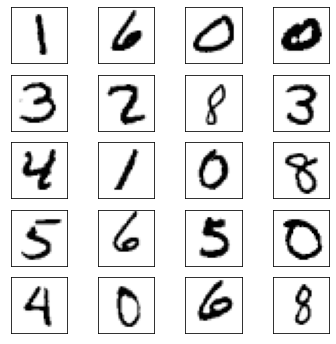

In [8]:
# create figure for plotting
row_num = 5
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
for k in range(row_num*col_num):
    i = k//col_num
    j = k%col_num
    ax[i,j].cla() # clear the current axis
    ax[i,j].imshow(img[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')

In [9]:
import torchvision.models.resnet as resnet

In [10]:
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [11]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes = 1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #x.shape = [1, 16, 32, 32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape = [1, 128, 32, 32]
        x = self.layer2(x)
        #x.shape = [1, 256, 32, 32]
        x = self.layer3(x)
        #x.shape = [1, 512, 16, 16]
        x = self.layer4(x)
        #x.shape = [1, 1024, 8, 8]

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [12]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device)
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) + 1(fc) = ResNet50

In [13]:
a = torch.Tensor(1, 1, 32, 32).to(device)
out = resnet50(a)
print(out)

tensor([[-0.1855, -0.1631,  0.2248,  0.0124,  0.1991, -0.0391, -0.2599, -0.2178,
         -0.2256,  0.6457]], device='cuda:0', grad_fn=<AddmmBackward>)


In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 0.01)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.5)

In [15]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' %acc)
    return acc

In [16]:
print(len(train_loader))
epochs = 15

for epoch in range(epochs):

    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0

    acc = acc_check(resnet50, val_loader, epoch, save=1)

print('Finished Training')

1200
[1,   300] loss: 5.039
[1,   600] loss: 1.485
[1,   900] loss: 0.970
[1,  1200] loss: 0.854
Accuracy of the network on the 10000 test images: 97 %
[2,   300] loss: 0.695
[2,   600] loss: 0.678
[2,   900] loss: 0.671
[2,  1200] loss: 0.476
Accuracy of the network on the 10000 test images: 98 %
[3,   300] loss: 0.557
[3,   600] loss: 0.538
[3,   900] loss: 0.464
[3,  1200] loss: 0.459
Accuracy of the network on the 10000 test images: 98 %
[4,   300] loss: 0.439
[4,   600] loss: 0.454
[4,   900] loss: 0.455
[4,  1200] loss: 0.421
Accuracy of the network on the 10000 test images: 98 %
[5,   300] loss: 0.354
[5,   600] loss: 0.407
[5,   900] loss: 0.370
[5,  1200] loss: 0.374
Accuracy of the network on the 10000 test images: 99 %
[6,   300] loss: 0.309
[6,   600] loss: 0.351
[6,   900] loss: 0.322
[6,  1200] loss: 0.332
Accuracy of the network on the 10000 test images: 99 %
[7,   300] loss: 0.306
[7,   600] loss: 0.288
[7,   900] loss: 0.285
[7,  1200] loss: 0.245
Accuracy of the netwo

In [19]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {:.3f}%'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99.783%
